# Protein set enrichment analysis

## Protein universes

* Full proteome
* Basal abundance HEK239 (T)
* Detected at least once
* Frequently detected
* Enriched at least once
* Frequently enriched

## Query lists

* Ranked
* Binarized

## Protein annotation sets
* Subcellular location
* Domains
* Pathways
* ...

In [1]:
import pandas as pd
import csv

In [19]:
# GO data from downloaded from UniProt

df = pd.read_csv("../data/raw/uniprot_human_proteome_simple_annotations.tab", sep="\t")

R = []
for r in df[["Entry", "Gene ontology (biological process)"]].values:
    pid = str(r[0])
    ann = str(r[1])
    if ann == "nan":
        continue
    ann = ann.split("; ")
    for x in ann:
        R += [[pid, x]]
with open("../data/annotations/proteins/uniprot_go_bp.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

R = []
for r in df[["Entry", "Gene ontology (molecular function)"]].values:
    pid = str(r[0])
    ann = str(r[1])
    if ann == "nan":
        continue
    ann = ann.split("; ")
    for x in ann:
        R += [[pid, x]]
with open("../data/annotations/proteins/uniprot_go_mf.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

R = []
for r in df[["Entry", "Gene ontology (cellular component)"]].values:
    pid = str(r[0])
    ann = str(r[1])
    if ann == "nan":
        continue
    ann = ann.split("; ")
    for x in ann:
        R += [[pid, x]]
with open("../data/annotations/proteins/uniprot_go_cc.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [31]:
# Reactome

## Complexes

df = pd.read_csv(
    "../data/raw/reactome/ComplexParticipantsPubMedIdentifiers_human.txt", sep="\t"
)

R = []
for r in df[["identifier", "name", "participants"]].values:
    ann = "{0} [{1}]".format(r[1], r[0])
    for x in r[2].split("|"):
        if x.startswith("uniprot"):
            pid = x.split("uniprot:")[-1]
            R += [[pid, ann]]

with open("../data/annotations/proteins/reactome_complexes.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

## Pathways

In [45]:
df = pd.read_csv(
    "../data/raw/reactome/UniProt2Reactome_All_Levels.txt", sep="\t", header=None
)
df.columns = ["pid", "rid", "url", "rname", "conf", "taxon"]

R = []
for r in df.values:
    if r[-1] != "Homo sapiens":
        continue
    ann = "{0} [{1}]".format(r[3], r[1])
    conf = r[4]
    R += [[r[0], ann, conf]]

with open("../data/annotations/proteins/reactome_pathways_all.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r[:2])

with open("../data/annotations/proteins/reactome_pathways_tas.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        if r[-1] != "TAS":
            continue
        writer.writerow(r[:2])

In [21]:
# interpro was run externally

import csv
import pandas as pd
import collections

R = []
with open("../data/raw/interpro/interpro.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if not r:
            continue
        R += [r]

Rs = set()
for r in R:
    Rs.update([tuple(r)])

df = pd.read_csv("../data/raw/interpro/entry.list", sep="\t")

entity = collections.defaultdict(list)

for r in df.values:
    entity[r[0]] += [r[1]]

values_per_entity = collections.defaultdict(list)

Rs = list(Rs)
Rs = sorted(Rs, key=lambda x: x[0])
for r in list(Rs):
    pid = r[0]
    ann = r[1]
    ent = ann.split("]")[0].split("[")[-1]
    for x in entity[ent]:
        values_per_entity[x] += [[pid, ann]]

for k, v in values_per_entity.items():
    with open(
        "../data/annotations/proteins/interpro_{0}.tsv".format(k.lower()), "w"
    ) as f:
        writer = csv.writer(f, delimiter="\t")
        for x in v:
            writer.writerow(x)

In [6]:
# Protein atlas

df = pd.read_csv("../data/raw/human_protein_atlas/protein_atlas_subcellular_location.tsv", sep="\t")
da = pd.read_csv("../data/raw/human_protein_atlas/proteinatlas.tsv", sep="\t")

In [9]:
ensembl2pid = {}
for r in da[["Ensembl", "Uniprot"]].values:
    if str(r[1]) == "nan":
        continue
    ensembl2pid[r[0]] = r[1]

gene2pid = {}
for r in da[["Gene", "Uniprot"]].values:
    if str(r[1]) == "nan":
        continue
    gene2pid[r[0]] = r[1]


In [16]:
slm = []
sla = []
for r in df[["Gene", "Gene name", "Main location", "Additional location"]].values:
    if r[0] in ensembl2pid:
        pid = ensembl2pid[r[0]]
    else:
        if r[1] in gene2pid:
            pid = gene2pid[r[1]]
        else:
            continue
    if str(r[2]) != "nan":
        m = r[2].split(";")
    else:
        m = []
    if str(r[3]) != "nan":
        a = r[3].split(";")
    else:
        a = []
    m = list(set(m))
    a = list(set(m+a))
    for x in m:
        slm += [[pid, x]]
    for x in a:
        sla += [[pid, x]]

In [20]:
with open("../data/annotations/proteins/protein_atlas_subcellular_location_main.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in slm:
        writer.writerow(r)

with open("../data/annotations/proteins/protein_atlas_subcellular_location_all.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in sla:
        writer.writerow(r)

In [11]:
# corum complexes

import pandas as pd

dc = pd.read_csv("../data/raw/corum/allComplexes.txt", delimiter="\t")

dc = dc[dc["Organism"]=="Human"]

R = []
for v in dc[["ComplexName", "subunits(UniProt IDs)"]].values:
    for x in v[1].split(";"):
        R += [[x, v[0]]]

import csv
with open("../data/annotations/proteins/corum_complexes.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [21]:
df = pd.read_csv("../data/processed/cemm_primary_data.tsv", delimiter="\t")

In [33]:
exp_id = list(set(df[df["FragID"] == "C001"]["expID"]))[0]
universe = sorted(set(df[df["expID"] == exp_id]["UniProtID"]))

In [34]:
len(universe)

3579

In [57]:
# Universes

# Human proteome
pids = sorted(
    set(
        pd.read_csv(
            "../data/raw/human_proteome_reference_with_sequences.tab", sep="\t"
        )["Entry"]
    )
)
with open("../data/universes/proteins/human_proteome.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for p in pids:
        writer.writerow([p])
human = set(pids)

# HEK293T observed proteome
df = pd.read_csv(
    "../data/raw/CC_GW_92_P11988_M1001_A01-E04_HEK293T_Proteins.txt", delimiter="\t"
)
df = df[df["Found in Sample in S1 F1 Sample"] == "High"]
pids = sorted(set([x.split("-")[0] for x in list(df["Accession"])]))
with open("../data/universes/proteins/hek293t_core.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for p in pids:
        if p not in human:
            continue
        writer.writerow([p])

In [68]:
# BD detected
df = pd.read_csv("../data/processed/cemm_primary_detected_data.tsv", delimiter="\t")
pids = sorted(set(df["UniProtID"]))
with open("../data/universes/proteins/cemm_detected.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for p in pids:
        if p not in human:
            continue
        writer.writerow([p])

# BD detected in at least 200 fragments (data driven)
detcounts = collections.defaultdict(int)
for r in list(df["UniProtID"]):
    detcounts[r] += 1

pids = sorted([k for k, v in detcounts.items() if v > 200])
with open("../data/universes/proteins/cemm_detected_frequently.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for p in pids:
        if p not in human:
            continue
        writer.writerow([p])

In [69]:
# BD enriched
df = pd.read_csv("../data/processed/cemm_primary_hit_data.tsv", delimiter="\t")
pids = sorted(set(df["UniProtID"]))
with open("../data/universes/proteins/cemm_enriched.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for p in pids:
        if p not in human:
            continue
        writer.writerow([p])

In [3]:
import pandas as pd

# Signatures

# Fragment specific

dd = pd.read_csv("../data/general/cemm_primary_detected_data.tsv", delimiter="\t")
de = pd.read_csv("../data/general/cemm_primary_hit_data.tsv", delimiter="\t")

In [4]:
from networkx.algorithms import bipartite
import networkx as nx

B = nx.Graph()
B.add_nodes_from(sorted(set(de["FragID"])), bipartite=0)
B.add_nodes_from(sorted(set(de["UniProtID"])), bipartite=1)

pairs = []
for r in de[["FragID", "UniProtID"]].values:
    pairs += [(r[0], r[1])]

B.add_edges_from(pairs)

In [5]:
fids_e = sorted(set(de["FragID"]))
frag_betweenness_centrality = bipartite.centrality.betweenness_centrality(B, nodes=fids_e)
frag_closeness_centrality = bipartite.centrality.closeness_centrality(B, nodes=fids_e)
frag_degree_centrality = bipartite.centrality.degree_centrality(B, nodes=fids_e)

In [6]:
pids_e = sorted(set(de["UniProtID"]))
prot_betweenness_centrality = bipartite.centrality.betweenness_centrality(B, nodes=pids_e)
prot_closeness_centrality = bipartite.centrality.closeness_centrality(B, nodes=pids_e)
prot_degree_centrality = bipartite.centrality.degree_centrality(B, nodes=pids_e)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,
          2.,   2.,   2.,   8.,   3.,   4.,  11.,  12.,  18.,  13.,  20.,
         24.,  26.,  37.,  43.,  43.,  41.,  70.,  59.,  75.,  82.,  85.,
         91., 112.,  85., 101., 106., 106., 106., 106., 103., 100.,  95.,
         91.,  84.,  80.,  71.,  66.,  59.,  53.,  45.,  39.,  34.,  30.,
         25.,  20.,  17.,  13.,  11.,   9.,   7.,   6.,   3.,   4.,   1.,
          4.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-5.19933758e+00, -5.09535083e+00, -4.99136408e+00, -4.88737733e+00,
        -4.78339058e+00, -4.67940382e+00, -4.57541707e+00, -4.47143032e+00,
        -4.36744357e+00, -4.26345682e+00, -4.15947007e+00, -4.05548331e+00,
        -3.95149656e+00, -3.84750981e+00, -3.74352306e+00, -3.63953631e+00,
        -3.535

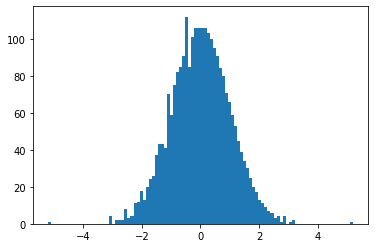

In [67]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

R = []
for pid in pids_e:
    R += [[prot_degree_centrality[pid], prot_betweenness_centrality[pid], prot_closeness_centrality[pid]]]

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

trf = PowerTransformer()
#trf = QuantileTransformer(output_distribution="normal")
X = trf.fit_transform(R)
X = np.mean(X, axis=1)
R = []
for x in X:
    R += [[x]]
trf = QuantileTransformer(output_distribution="normal")
X = trf.fit_transform(R).ravel()


#plt.scatter(X[:,0],X[:,2])

In [79]:
idxs = np.argsort(-X)

promiscuity = []
for i in idxs:
    promiscuity += [[pids_e[i], X[i]]]

with open("../data/signatures/proteins/global/promiscuity/promiscuity_gauss.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in promiscuity:
        writer.writerow(r)

In [83]:
for t in [50, 100, 250, 500]:
    R = promiscuity[:t]
    with open("../data/signatures/proteins/global/promiscuity/promiscuity_top_{0}.tsv".format(t), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for r in R:
            writer.writerow([r[0]])

for t in [50, 100, 250, 500]:
    R = promiscuity[-t:]
    with open("../data/signatures/proteins/global/promiscuity/promiscuity_bottom_{0}.tsv".format(t), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for r in R:
            writer.writerow([r[0]])


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
from sklearn.preprocessing import QuantileTransformer

dd_counts = collections.defaultdict(int)
dd_upeps = collections.defaultdict(int)
for r in dd[["UniProtID", "UniqPeptides"]].values:
    dd_counts[r[0]] += 1
    dd_upeps[r[0]] += r[1]

R = []
pids_d = []
for k,v in dd_counts.items():
    R += [[v, dd_upeps[k]]]
    pids_d += [k]

trf = QuantileTransformer(output_distribution="normal")
X = trf.fit_transform(R)
X = np.mean(X, axis=1)
R = []
for x in X:
    R += [[x]]
trf = QuantileTransformer(output_distribution="normal")
X = trf.fit_transform(R).ravel()

In [9]:
import csv

idxs = np.argsort(-X)

detectability = []
for i in idxs:
    detectability += [[pids_d[i], X[i]]]

with open("../data/signatures/proteins/global/detectability/detectability_gauss.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in detectability:
        writer.writerow(r)

for t in [50, 100, 250, 500]:
    R = detectability[:t]
    with open("../data/signatures/proteins/global/detectability/detectability_top_{0}.tsv".format(t), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for r in R:
            writer.writerow([r[0]])

for t in [50, 100, 250, 500]:
    R = detectability[-t:]
    with open("../data/signatures/proteins/global/detectability/detectability_bottom_{0}.tsv".format(t), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for r in R:
            writer.writerow([r[0]])

In [23]:
det = {}
with open("../data/signatures/proteins/global/detectability/detectability_gauss.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        det[r[0]] = float(r[1])

prom = {}
with open("../data/signatures/proteins/global/promiscuity/promiscuity_gauss.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        prom[r[0]] = float(r[1])

(array([1.740e+02, 2.014e+03, 3.050e+02, 7.800e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.34544274, 0.49934016, 0.65323758, 0.807135  , 0.96103242,
        1.11492983, 1.26882725, 1.42272467, 1.57662209, 1.73051951,
        1.88441692]),
 <BarContainer object of 10 artists>)

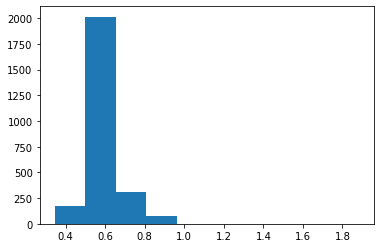

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

a = []
for k,v in prot_closeness_centrality.items():
    if k.startswith("C"):
        continue
    a += [(k,v)]


a = sorted(a, key=lambda x: -x[1])

plt.hist([x[1] for x in a])

In [46]:
a[:10]

[('P05166', 1.8844169246646025),
 ('Q9NS69', 0.9368870727623945),
 ('P30519', 0.92799307783534),
 ('P80303', 0.9270501551482931),
 ('O43169', 0.9254828683264025),
 ('P21796', 0.9186492978940545),
 ('P24390', 0.9177252583655777),
 ('P43307', 0.9171102640560681),
 ('Q99595', 0.9168030758919228),
 ('P45880', 0.9146585072933452)]

In [2]:

frag2values = collections.defaultdict(list)
for r in dd[["FragID", "UniProtID", "Log2FC"]].values:
    frag2values[r[0]] += [(r[1], r[2])]

frag2values = dict((k, sorted(v, key=lambda x: -x[1])) for k, v in frag2values.items())

frag2hits = collections.defaultdict(set)
for r in de[["FragID", "UniProtID"]].values:
    frag2hits[r[0]].update([r[1]])

NameError: name 'collections' is not defined

In [ ]:
from tqdm import tqdm
import numpy as np

prot2ranks = collections.defaultdict(list)
for k, v in tqdm(frag2values.items()):
    for i, x in enumerate(v):
        prot2ranks[x[0]] += [i]

prot2ranks_mean = dict((k, np.mean(v)) for k, v in prot2ranks.items())
prot2ranks_std = dict((k, np.std(v)) for k, v in prot2ranks.items())

In [1]:
import os
import shutil

for k, v in frag2values.items():
    dirname = os.path.join("../data/signatures/proteins/fragment/", k)
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    with open(os.path.join(dirname, "{0}_val_log2fc.tsv".format(k)), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for x in v:
            writer.writerow(x)
    #with open(os.path.join(dirname, "{0}_val_zrank.tsv".format(k)), "w") as f:
    #    writer = csv.writer(f, delimiter="\t")
    #    for i, x in enumerate(v):
    #        z = (prot2ranks_mean[x[0]] - i) / prot2ranks_std[x[0]]
    #        writer.writerow([x[0], z])
    for top in [50, 100, 250, 500]:
        v_ = v[:top]
        with open(os.path.join(dirname, "{0}_bin_{1}.tsv".format(k, top)), "w") as f:
            writer = csv.writer(f, delimiter="\t")
            for x in v_:
                writer.writerow([x[0]])
    hits = frag2hits[k]
    hits = [x[0] for x in v if x[0] in hits]
    with open(os.path.join(dirname, "{0}_bin_hit.tsv".format(k)), "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for x in hits:
            writer.writerow([x])

NameError: name 'frag2values' is not defined

In [119]:
# Global properties of proteins

# Detectability
dirname = os.path.join("../data/signatures/proteins/global/detectability")
if os.path.exists(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)
d = collections.defaultdict(int)
for p in list(dd["UniProtID"]):
    d[p] += 1
v = sorted(d.items(), key=lambda x: -x[1])
with open(os.path.join(dirname, "detectability_val_counts.tsv"), "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for x in v:
        writer.writerow(x)
for top in [1500, 3000]:
    with open(os.path.join(dirname, "detectability_bin_{0}.tsv".format(top)), "w") as f:
        v_ = v[:top]
        writer = csv.writer(f, delimiter="\t")
        for x in v_:
            writer.writerow([x[0]])

# Number of hits
dirname = os.path.join("../data/signatures/proteins/global/promiscuity_hit")
if os.path.exists(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)
d = collections.defaultdict(int)
for p in list(de["UniProtID"]):
    d[p] += 1
v = sorted(d.items(), key=lambda x: -x[1])
with open(os.path.join(dirname, "promiscuity_hit_val_counts.tsv"), "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for x in v:
        writer.writerow(x)
for top in [50, 100, 250, 500]:
    with open(
        os.path.join(dirname, "promiscuity_hit_bin_{0}.tsv".format(top)), "w"
    ) as f:
        v_ = v[:top]
        writer = csv.writer(f, delimiter="\t")
        for x in v_:
            writer.writerow([x[0]])

In [191]:
# tfidf_specificity

from sklearn.feature_extraction.text import TfidfTransformer

dirname = os.path.join("../data/signatures/proteins/global/tfidf_specificity")
if os.path.exists(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)
pairs = []
for v in de[["UniProtID", "FragID"]].values:
    pairs += [(v[0], v[1])]
pairs = set(pairs)

pids = sorted(set([p[0] for p in pairs]))
fids = sorted(set([p[1] for p in pairs]))
X = np.zeros((len(pids), len(fids)))
for i, pid in enumerate(pids):
    for j, fid in enumerate(fids):
        if (pid, fid) in pairs:
            X[i, j] += 1

transf = TfidfTransformer()
Tp = np.array(transf.fit_transform(X).todense())
spec = 1 / np.sum(Tp, axis=1)

d = {}
for p, s in zip(pids, spec):
    d[p] = s
d = sorted(d.items(), key=lambda x: -x[1])

with open(os.path.join(dirname, "tfidf_specificity_val_by_sum.tsv"), "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in d:
        writer.writerow(r)

transf = TfidfTransformer()
Tf = np.array(transf.fit_transform(X.T).todense())
fspec = 1 / np.sum(Tf, axis=1)

d = {}
for i, pid in enumerate(pids):
    mask = X[i, :] > 0
    d[pid] = np.mean(fspec[mask])
d = sorted(d.items(), key=lambda x: -x[1])

with open(os.path.join(dirname, "tfidf_specificity_val_by_mean_frag.tsv"), "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in d:
        writer.writerow(r)

In [10]:
# Test enrichment functions

import csv

R = []
with open("../data/raw/paralogy/human_uniprot_paralogID.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        R += [(r[0], "ID:"+r[2])]

R = list(set(R))

with open("../data/annotations/proteins/paralogy_groups.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)


In [21]:
# Pharos

import pandas as pd
df = pd.read_csv("../data/raw/pharos/dto/query results.csv")

R = []
for r in df[df["DTO Class"].notnull()].values:
    R += [[r[1], r[3]]]

with open("../data/annotations/proteins/pharos_dto.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [89]:
# Complex Portal

df = pd.read_csv("../data/raw/complex_portal/complex_portal_9606.tsv", delimiter="\t")

R = []
for r in df.values:
    v = "{0} [{1}]".format(r[1], r[0])
    p = r[4].split("|")
    for x in p:
        x = x.split("(")[0]
        if x.startswith("["):
            y = x.split("[")[1].split("]")[0].split(",")
        else:
            y = [x]
        for x_ in y:
            if x_.startswith("CHEBI"):
                continue
            if x_.startswith("CPX"):
                continue
            x_ = x_.split("-")[0]
            if "_" in x_:
                continue
            R += [[x_,v]]
    
with open("../data/annotations/proteins/complex_portal.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [96]:
# MSigDB

gene2pid = collections.defaultdict(list)

df = pd.read_csv("../data/raw/human_proteome_with_gene_names.tab", delimiter="\t")

for r in df.values:
    pid = r[0]
    if str(r[2]) == "nan":
        continue
    gnames = r[2].split(" ")
    for g in gnames:
        g = g.replace(";", "")
        gene2pid[g] += [pid]



In [107]:
path = "../data/raw/msigdb"

msigdb = collections.defaultdict(list)
for l in os.listdir(path):
    gmt_file = os.path.join(path, l)
    with open(gmt_file, "r") as f:
        for r in f:
            r = r.rstrip("\n")
            r = r.split("\t")
            ann = r[0]
            db = ann.split("_")[0].lower()
            ann = " ".join(ann.split("_")[1:]).capitalize()
            genes = r[2:]
            for g in genes:
                if g in gene2pid:
                    for pid in gene2pid[g]:
                        msigdb[db] += [[pid, ann]]

In [109]:
for k,v in msigdb.items():
    fn = "../data/annotations/proteins/msigdb_{0}.tsv".format(k)
    with open(fn, "w") as f:
        writer = csv.writer(f, delimiter="\t")
        for r in v:
            writer.writerow(r)

In [116]:
# OpenCell

df = pd.read_csv("../data/raw/opencell/opencell-localization-annotations.csv")

R = []
for r in df.values:
    g = r[0]
    if g not in gene2pid:
        continue
    for pid in gene2pid[g]:
        pass
        for a in r[2:]:
            if str(a) == "nan":
                continue
            for a_ in a.split(";"):
                R += [[pid, a_]]

with open("../data/annotations/proteins/opencell_localization.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [115]:
R

[['Q13685', 'cytoplasmic'],
 ['Q13685', 'nucleoplasm'],
 ['Q9NY61', 'nucleolus_gc'],
 ['P61221', 'cytoplasmic'],
 ['P61221', 'vesicles'],
 ['P61221', 'nucleoplasm'],
 ['Q12979', 'cytoplasmic'],
 ['Q12979', 'vesicles'],
 ['Q15057', 'cytoplasmic'],
 ['Q96P50', 'cytoplasmic'],
 ['Q96P50', 'mitochondria'],
 ['Q96P50', 'big_aggregates'],
 ['P53396', 'cytoplasmic'],
 ['P53396', 'nucleoplasm'],
 ['P60709', 'membrane'],
 ['P60709', 'cytoskeleton'],
 ['P60709', 'cytoplasmic'],
 ['P63261', 'membrane'],
 ['P63261', 'cytoskeleton'],
 ['P63261', 'cytoplasmic'],
 ['P12814', 'membrane'],
 ['P12814', 'cytoskeleton'],
 ['O43707', 'membrane'],
 ['O43707', 'cytoskeleton'],
 ['P61160', 'membrane'],
 ['P61160', 'vesicles'],
 ['P61160', 'cytoplasmic'],
 ['Q9H9F9', 'nucleoplasm'],
 ['Q9H9F9', 'chromatin'],
 ['Q9UPQ3', 'cytoplasmic'],
 ['Q9UPQ3', 'cell_contact'],
 ['Q9UPQ3', 'membrane'],
 ['Q96P47', 'nucleoplasm'],
 ['Q96P47', 'cytoplasmic'],
 ['Q96P47', 'cell_contact'],
 ['Q9UL18', 'cytoplasmic'],
 ['Q9UKV8'

In [61]:
import collections

# CavitySpace

df = pd.read_csv("../data/raw/cavityspace/AF-cavities.idx", delimiter="\t")
dc = pd.read_csv("../data/raw/cavityspace/cavity_cluster_similarity07.csv", delimiter="\t")

df = df[df["pred_max_pkd"] >= 6] # this does not remove much

cavity_clusters = {}
for r in dc.values:
    cid = r[0]
    items = r[2]
    for x in items.split(","):
        cavity_clusters[x] = "ID:{0}".format(cid)

R = []
for r in df.values:
    if r[0] not in cavity_clusters:
        continue
    R += [[r[1], cavity_clusters[r[0]]]]

with open("../data/annotations/proteins/cavityspace_all.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

df = df[df["druggability"] == "Strong"]

R = []
for r in df.values:
    if r[0] not in cavity_clusters:
        continue
    R += [[r[1], cavity_clusters[r[0]]]]

with open("../data/annotations/proteins/cavityspace_strong.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)


(237872, 14)
(208060, 14)


In [15]:
# MLOS metadb

import pandas as pd
import csv

df = pd.read_csv("../data/raw/mlos/mlosmetadb_dataset.csv")

df = df[df["Organism"] == "Homo sapiens"]
df = df[df["Mlos"].notnull()]

R = []
for r in df[["Uniprot", "Mlos"]].values:
    for x in r[1].split(", "):
        R += [[r[0], x]]

with open("../data/annotations/proteins/mlosmetadb.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

In [21]:
# MLOS disdb

import pandas as pd
import csv

df = pd.read_csv("../data/raw/mlosdisdb/mlodisdb_components.csv")

df = df[df["MLO"].notnull()]

R = []
for r in df[["Entry", "MLO"]].values:
    R += [[r[0], r[1]]]

with open("../data/annotations/proteins/mlosdisdb.tsv", "w") as f:
    writer = csv.writer(f, delimiter="\t")
    for r in R:
        writer.writerow(r)

print(R)

[['A5A3E0', 'Cajal body'], ['O00300', 'Cajal body'], ['O00566', 'Cajal body'], ['O00567', 'Cajal body'], ['O14744', 'Cajal body'], ['O14746', 'Cajal body'], ['O14773', 'Cajal body'], ['O14980', 'Cajal body'], ['O43189', 'Cajal body'], ['O43290', 'Cajal body'], ['O43623', 'Cajal body'], ['O60832', 'Cajal body'], ['O75147', 'Cajal body'], ['O75475', 'Cajal body'], ['O75525', 'Cajal body'], ['O75616', 'Cajal body'], ['O75665', 'Cajal body'], ['O75940', 'Cajal body'], ['O95149', 'Cajal body'], ['O95361', 'Cajal body'], ['O95453', 'Cajal body'], ['P00533', 'Cajal body'], ['P00742', 'Cajal body'], ['P00915', 'Cajal body'], ['P00918', 'Cajal body'], ['P01148', 'Cajal body'], ['P01185', 'Cajal body'], ['P01189', 'Cajal body'], ['P01213', 'Cajal body'], ['P01241', 'Cajal body'], ['P01308', 'Cajal body'], ['P01350', 'Cajal body'], ['P01584', 'Cajal body'], ['P01588', 'Cajal body'], ['P02511', 'Cajal body'], ['P02647', 'Cajal body'], ['P02741', 'Cajal body'], ['P02760', 'Cajal body'], ['P02768', 

In [124]:
fxp = collections.defaultdict(int)
for p in pairs:
    fxp[p[0]] += 1
pxf = collections.defaultdict(int)
for p in pairs:
    pxf[p[1]] += 1
fop = collections.defaultdict(list)
for p in pairs:
    fop[p[0]] += [p[1]]
d = {}
for k, v in fop.items():
    vals = []
    for x in v:
        vals += [pxf[x]]
    d[k] = np.median(vals)

(array([ 21.,  90., 117., 206., 535., 695., 605., 176.,  77.,  50.]),
 array([  1. ,  48.1,  95.2, 142.3, 189.4, 236.5, 283.6, 330.7, 377.8,
        424.9, 472. ]),
 <BarContainer object of 10 artists>)

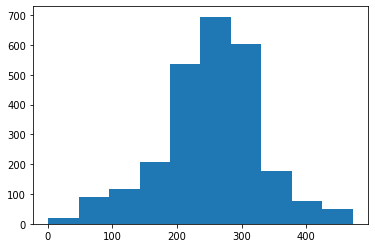

In [129]:
plt.hist([v for k, v in d.items()])

(array([128.,  46.,  23.,  28.,  35.,  27.,  30.,  10.,   4.,   5.]),
 array([  1. ,  48.1,  95.2, 142.3, 189.4, 236.5, 283.6, 330.7, 377.8,
        424.9, 472. ]),
 <BarContainer object of 10 artists>)

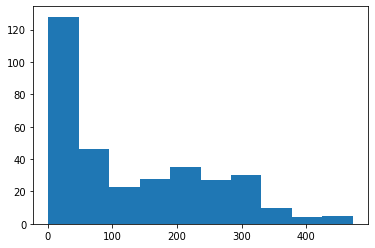

In [130]:
plt.hist([v for k, v in pxf.items()])

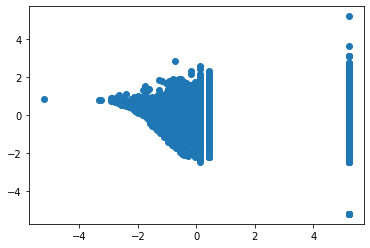

In [152]:
from sklearn.preprocessing import QuantileTransformer

x = []
y = []
labs = []
for k, v in d.items():
    labs += [k]
    y += [v]
    x += [fxp[k]]
x = np.array(x)
y = np.array(y)

data = pd.DataFrame({"x": -x, "y": -y})
transf = QuantileTransformer(output_distribution="normal")
transf.fit(data)
data = transf.transform(data)

plt.scatter(data[:, 0], data[:, 1])

In [137]:
from scipy.stats import rankdata

rankdata(x, method="ordinal")

array([ 695, 1794,  696, ..., 1269, 1521, 1030])

[2,
 10,
 2,
 30,
 2,
 1,
 2,
 15,
 2,
 1,
 1,
 129,
 1,
 1,
 4,
 97,
 3,
 5,
 2,
 34,
 5,
 30,
 31,
 2,
 2,
 1,
 1,
 16,
 87,
 2,
 52,
 6,
 2,
 145,
 9,
 1,
 14,
 1,
 1,
 30,
 7,
 26,
 1,
 18,
 16,
 1,
 12,
 5,
 4,
 11,
 1,
 12,
 1,
 13,
 1,
 5,
 6,
 37,
 1,
 110,
 1,
 1,
 5,
 5,
 9,
 2,
 1,
 96,
 1,
 3,
 128,
 1,
 1,
 2,
 3,
 3,
 42,
 1,
 1,
 8,
 6,
 1,
 1,
 1,
 3,
 1,
 98,
 19,
 1,
 57,
 2,
 1,
 144,
 18,
 29,
 6,
 1,
 39,
 16,
 90,
 32,
 1,
 2,
 1,
 3,
 3,
 6,
 13,
 2,
 15,
 4,
 1,
 1,
 1,
 181,
 10,
 3,
 4,
 26,
 1,
 9,
 12,
 5,
 1,
 8,
 1,
 36,
 46,
 1,
 4,
 4,
 3,
 22,
 134,
 1,
 1,
 2,
 9,
 163,
 23,
 8,
 2,
 4,
 1,
 3,
 84,
 31,
 85,
 2,
 1,
 115,
 42,
 21,
 6,
 1,
 17,
 4,
 3,
 1,
 11,
 70,
 7,
 78,
 2,
 12,
 1,
 2,
 1,
 1,
 26,
 1,
 1,
 2,
 17,
 14,
 3,
 63,
 74,
 17,
 5,
 1,
 1,
 5,
 1,
 137,
 2,
 4,
 3,
 1,
 168,
 6,
 2,
 1,
 2,
 3,
 194,
 39,
 20,
 6,
 78,
 2,
 22,
 62,
 1,
 1,
 1,
 3,
 181,
 1,
 9,
 18,
 51,
 31,
 3,
 1,
 3,
 4,
 2,
 1,
 2,
 40,
 9,
 1,
 1,
 36,
 12,
 6,